# Carga de datos

In [1]:
import numpy as np
import pandas as pd

def cargar_datos_npz(ruta_archivo):
    """
    Carga un archivo .npz con datos de simulación y reales.
    
    Retorna:
    - df_modelo: DataFrame con columnas ['fecha', 'simulado']
    - df_reales: DataFrame con columnas ['fecha', 'real']
    """
    data = np.load(ruta_archivo, allow_pickle=True)
    
    fechas_modelo = pd.to_datetime(data['fechas_modelo'])
    simulados = data['simulados']
    
    fechas_reales = pd.to_datetime(data['fechas_reales'])
    reales = data['reales']
    
    df_modelo = pd.DataFrame({
        'fecha': fechas_modelo,
        'real': simulados
    })
    
    df_reales = pd.DataFrame({
        'fecha': fechas_reales,
        'real': reales
    })
    
    return df_modelo, df_reales


In [2]:
# Para entrenamiento de Italia
df_modelo_it, df_reales_it = cargar_datos_npz('sir_italy_train.npz')

# Para test de Italia
df_modelo_it_test, df_reales_it_test = cargar_datos_npz('sir_italy_test.npz')

# Para entrenamiento de España
df_modelo_es, df_reales_es = cargar_datos_npz('sir_spain_train.npz')

# Para test de España
df_modelo_es_test, df_reales_es_test = cargar_datos_npz('sir_spain_test.npz')

# Para entrenamiento de Colombia
df_modelo_col, df_reales_col = cargar_datos_npz('sir_colombia_train.npz')

# Para test de Colombia
df_modelo_col_test, df_reales_col_test = cargar_datos_npz('sir_colombia_test.npz')



# Forward Neural Network

In [7]:
import torch
import torch.nn as nn

class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.net(x)

def entrenar_fnn(X_train, y_train, lr=0.01, epochs=5000):
    """
    Entrena una red FNN para ajustar los datos (X_train, y_train).
    """
    model = FNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    return model

def preparar_datos_fnn(df_train, df_test):
    """
    Prepara los tensores X_train, y_train, X_test a partir de los DataFrames con columnas 'fecha' y 'real'.
    """
    # Convertir fechas a días desde el inicio
    dias_train = (df_train['fecha'] - df_train['fecha'].iloc[0]).dt.days.values.reshape(-1, 1)
    dias_test = (df_test['fecha'] - df_train['fecha'].iloc[0]).dt.days.values.reshape(-1, 1)

    X_train = torch.tensor(dias_train, dtype=torch.float32)
    y_train = torch.tensor(df_train['real'].values.reshape(-1, 1), dtype=torch.float32)
    X_test = torch.tensor(dias_test, dtype=torch.float32)

    return X_train, y_train, X_test

import matplotlib.pyplot as plt

def graficar_fnn(model, df_train, df_test, X_train, X_test, label='Italia'):
    """
    Grafica el ajuste de la red FNN en entrenamiento y su predicción en test.
    """
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train).numpy().flatten()
        y_pred_test = model(X_test).numpy().flatten()

    # Gráfico de entrenamiento
    plt.figure(figsize=(12, 5))
    plt.plot(df_train['fecha'], df_train['real'], 'o', label='Datos reales (train)', color='black')
    plt.plot(df_train['fecha'], y_pred_train, '-', label='Predicción FNN (train)', color='green')
    plt.xlabel("Fecha")
    plt.ylabel("Infectados normalizados")
    plt.title(f"Ajuste FNN en entrenamiento ({label})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Gráfico de test
    plt.figure(figsize=(10, 5))
    plt.plot(df_test['fecha'], df_test['real'], 'o', label='Datos reales (test)', color='black')
    plt.plot(df_test['fecha'], y_pred_test, '-', label='Predicción FNN (test)', color='royalblue')
    plt.xlabel("Fecha")
    plt.ylabel("Infectados normalizados")
    if (label == 'Italia'):
        plt.ylim([0, 0.1])
    elif (label == 'España'):
        plt.ylim([0.1,0.35])
    plt.title(f"Predicción FNN en test ({label})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Epoch 0, Loss: 0.023154
Epoch 500, Loss: 0.000296
Epoch 1000, Loss: 0.000057
Epoch 1500, Loss: 0.000043
Epoch 2000, Loss: 0.000041
Epoch 2500, Loss: 0.000035
Epoch 3000, Loss: 0.000018
Epoch 3500, Loss: 0.000017
Epoch 4000, Loss: 0.000016
Epoch 4500, Loss: 0.000116


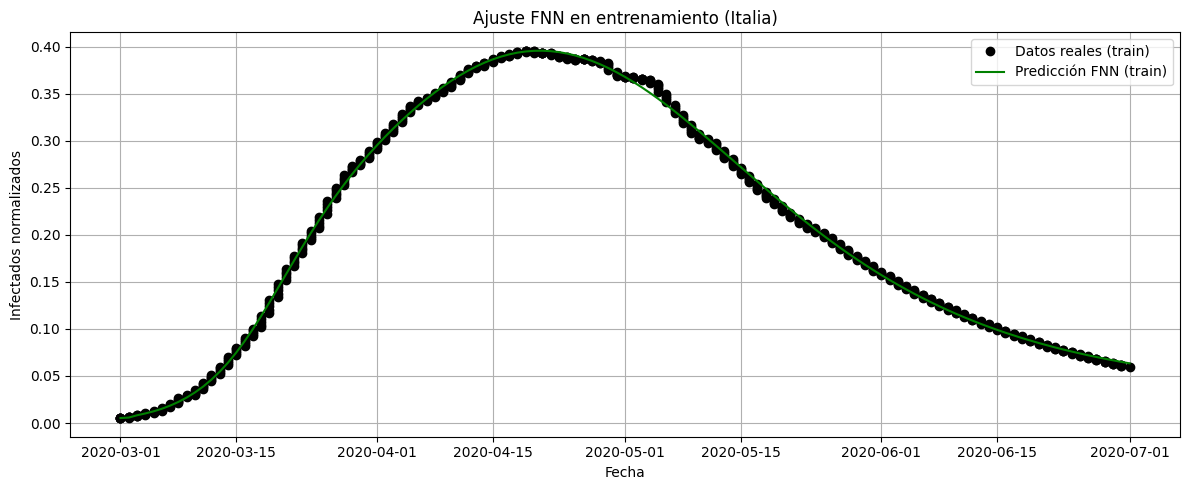

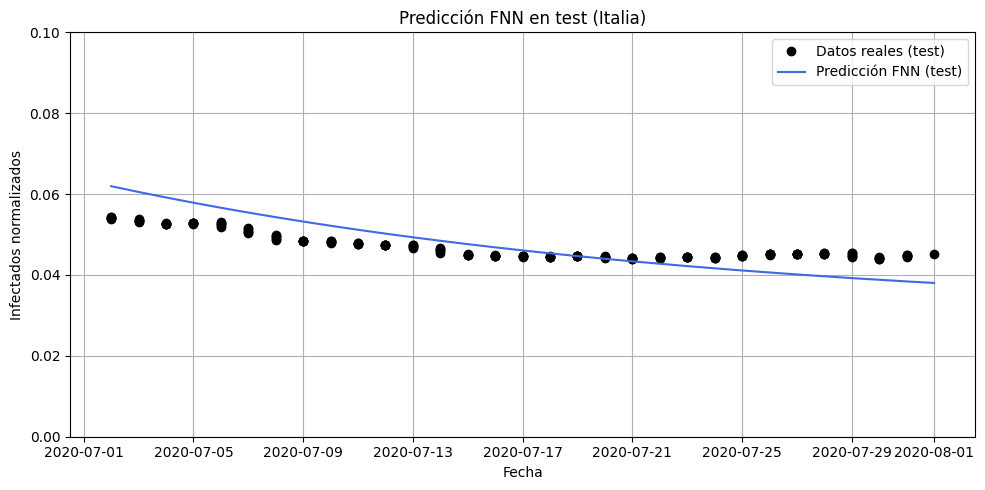

In [8]:
X_train, y_train, X_test = preparar_datos_fnn(df_modelo_it, df_modelo_it_test)
model = entrenar_fnn(X_train, y_train, lr=0.01, epochs=5000)
graficar_fnn(model, df_modelo_it, df_modelo_it_test, X_train, X_test, label='Italia')


Epoch 0, Loss: 0.125035
Epoch 500, Loss: 0.000022
Epoch 1000, Loss: 0.000020
Epoch 1500, Loss: 0.000019
Epoch 2000, Loss: 0.000017
Epoch 2500, Loss: 0.000016
Epoch 3000, Loss: 0.000015
Epoch 3500, Loss: 0.000015
Epoch 4000, Loss: 0.000014
Epoch 4500, Loss: 0.000014


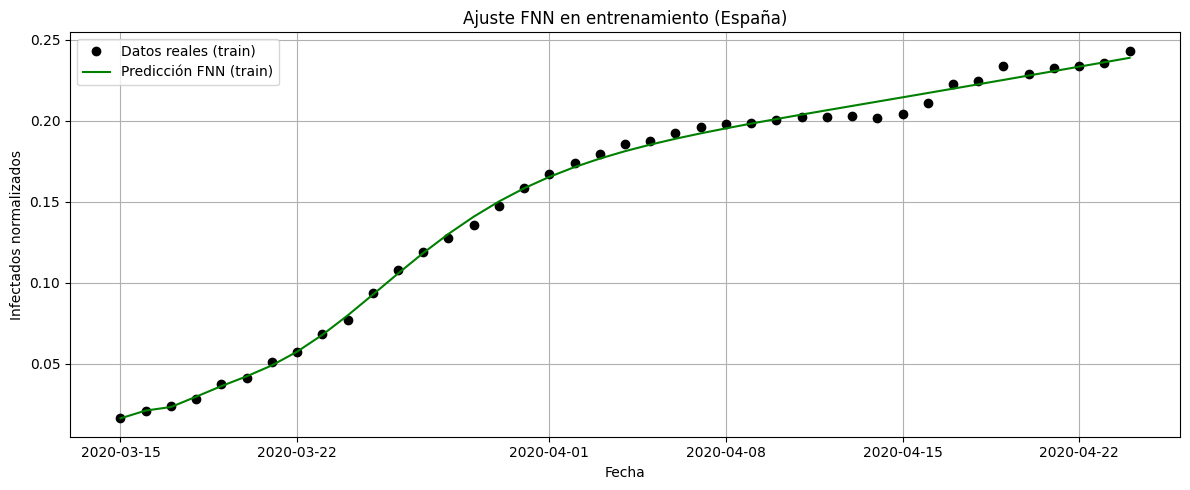

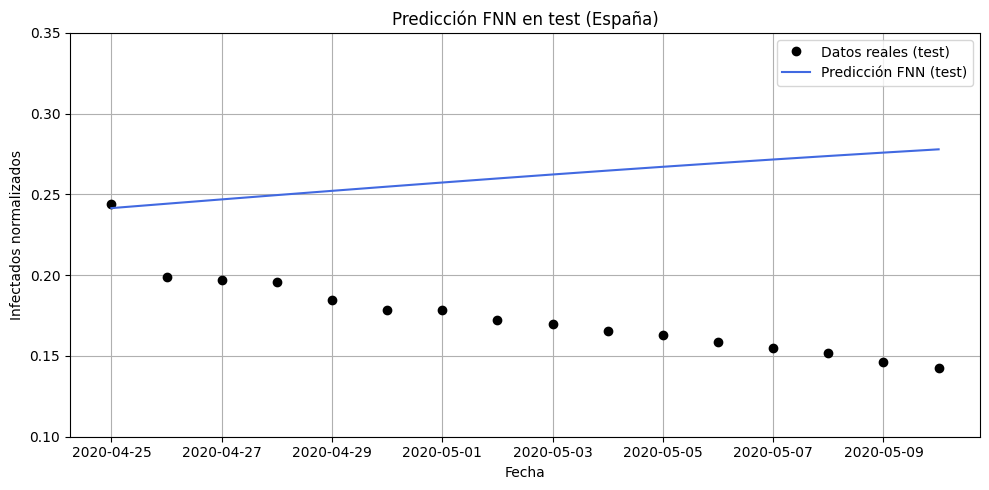

In [17]:
X_train, y_train, X_test = preparar_datos_fnn(df_reales_es, df_reales_es_test)
model = entrenar_fnn(X_train, y_train, lr=0.01, epochs=5000)
graficar_fnn(model, df_reales_es, df_reales_es_test, X_train, X_test, label='España')

Epoch 0, Loss: 0.128070
Epoch 500, Loss: 0.000021
Epoch 1000, Loss: 0.000020
Epoch 1500, Loss: 0.000019
Epoch 2000, Loss: 0.000022
Epoch 2500, Loss: 0.000017
Epoch 3000, Loss: 0.000017
Epoch 3500, Loss: 0.000016
Epoch 4000, Loss: 0.000015
Epoch 4500, Loss: 0.000014


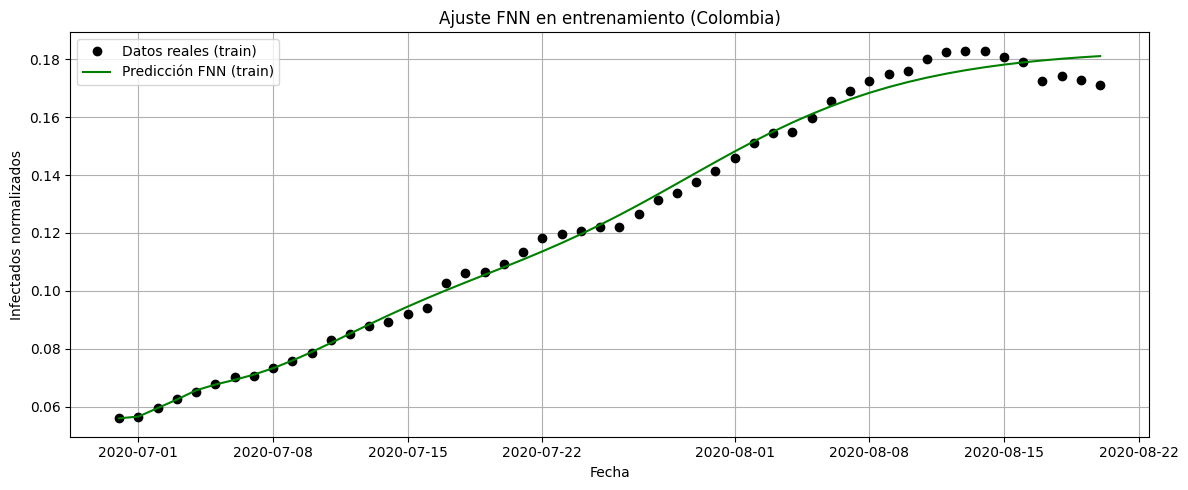

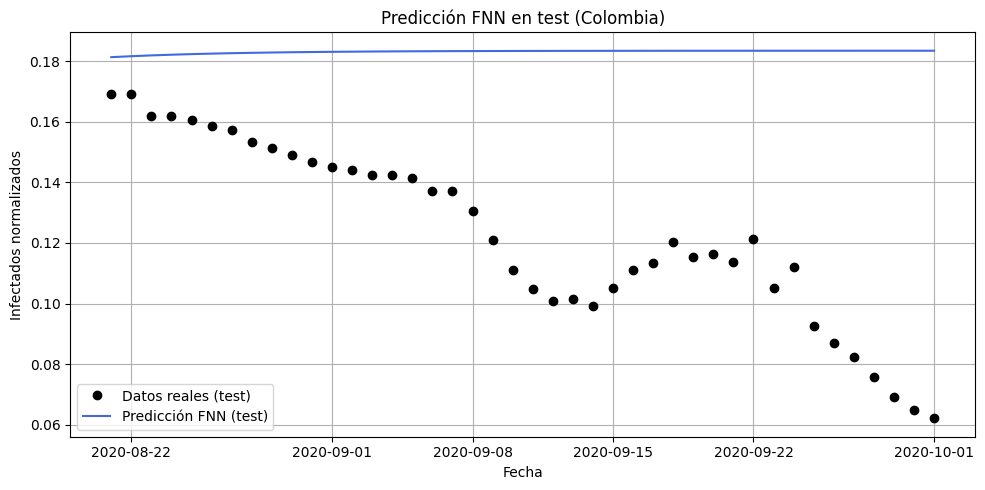

In [18]:
X_train, y_train, X_test = preparar_datos_fnn(df_reales_col, df_reales_col_test)
model = entrenar_fnn(X_train, y_train, lr=0.01, epochs=5000)
graficar_fnn(model, df_reales_col, df_reales_col_test, X_train, X_test, label='Colombia')

# NAR Neural Network

In [23]:
import torch
import torch.nn as nn

class NAR(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.net(x)
    
def preparar_datos_nar(df, d):
    """
    Prepara los pares (input, target) para una red NAR de ventana d.
    Entrada:
        df: DataFrame con columna 'real'
        d: número de días anteriores usados como input

    Retorna:
        X (N-d, d): tensor de entradas
        y (N-d, 1): tensor de salidas
        fechas: fechas correspondientes a cada y[n] (para graficar luego)
    """
    valores = df['real'].values.astype('float32')
    X = []
    y = []
    fechas = []

    for t in range(d, len(valores)):
        X.append(valores[t - d:t])
        y.append(valores[t])
        fechas.append(df['fecha'].iloc[t])

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

    return X_tensor, y_tensor, fechas

def entrenar_nar(X_train, y_train, d, lr=0.01, epochs=5000):
    model = NAR(d)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    return model


import matplotlib.pyplot as plt

def graficar_nar(model, X_train, y_train, fechas, df_test, d, label='País'):
    """
    Grafica la predicción en entrenamiento y test para una NAR.
    """
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train).numpy().flatten()

    # Gráfico de entrenamiento
    plt.figure(figsize=(12, 5))
    plt.plot(fechas, y_train.numpy().flatten(), 'o', label='Datos reales (train)', color='black')
    plt.plot(fechas, y_pred_train, '-', label='Predicción NAR (train)', color='green')
    plt.xlabel("Fecha")
    plt.ylabel("Infectados normalizados")
    plt.title(f"Ajuste NAR en entrenamiento ({label})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Test: predicción autoregresiva paso a paso ---
    test_values = list(df_test['real'].values[:d].astype('float32'))  # semillas
    predicciones = []

    model.eval()
    with torch.no_grad():
        for i in range(d, len(df_test)):
            input_seq = torch.tensor(test_values[-d:], dtype=torch.float32).reshape(1, -1)
            next_val = model(input_seq).item()
            predicciones.append(next_val)
            test_values.append(next_val)  # usar la predicción como input futuro

    # Fechas de test alineadas
    fechas_test = df_test['fecha'].iloc[d:].reset_index(drop=True)
    reales_test = df_test['real'].iloc[d:].reset_index(drop=True)

    # Gráfico de test
    plt.figure(figsize=(10, 5))
    plt.plot(fechas_test, reales_test, 'o', label='Datos reales (test)', color='black')
    plt.plot(fechas_test, predicciones, '-', label='Predicción NAR (test)', color='royalblue')
    plt.xlabel("Fecha")
    plt.ylabel("Infectados normalizados")
    if (label == 'Italia'):
        plt.ylim([-0.02, 0.13])
    elif (label == 'España'):
        plt.ylim([0.1,0.35])
    plt.title(f"Predicción autoregresiva NAR en test ({label})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Epoch 0, Loss: 0.220481
Epoch 500, Loss: 0.000031
Epoch 1000, Loss: 0.000012
Epoch 1500, Loss: 0.000002
Epoch 2000, Loss: 0.000001
Epoch 2500, Loss: 0.000001
Epoch 3000, Loss: 0.000001
Epoch 3500, Loss: 0.000001
Epoch 4000, Loss: 0.000001
Epoch 4500, Loss: 0.000001


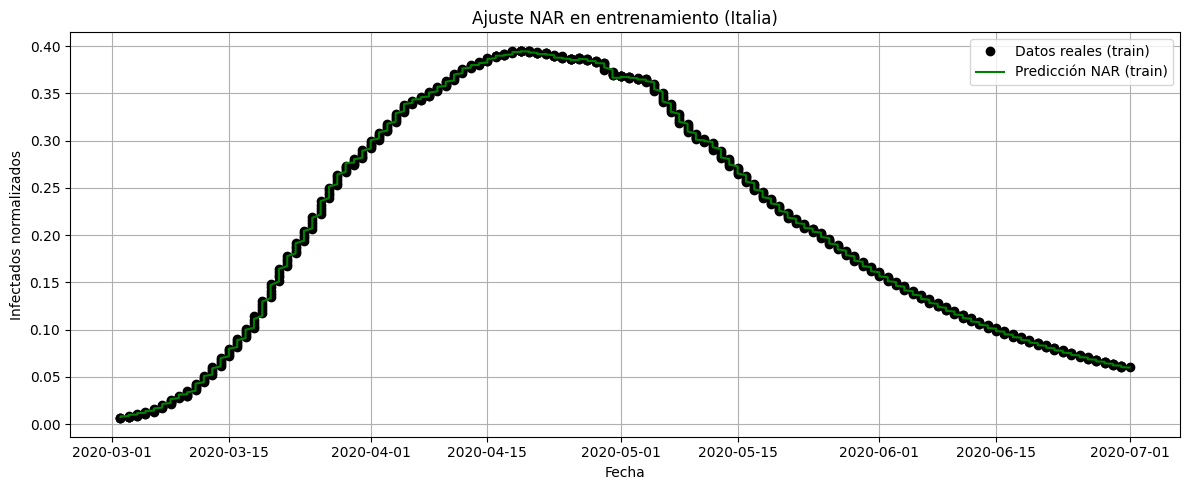

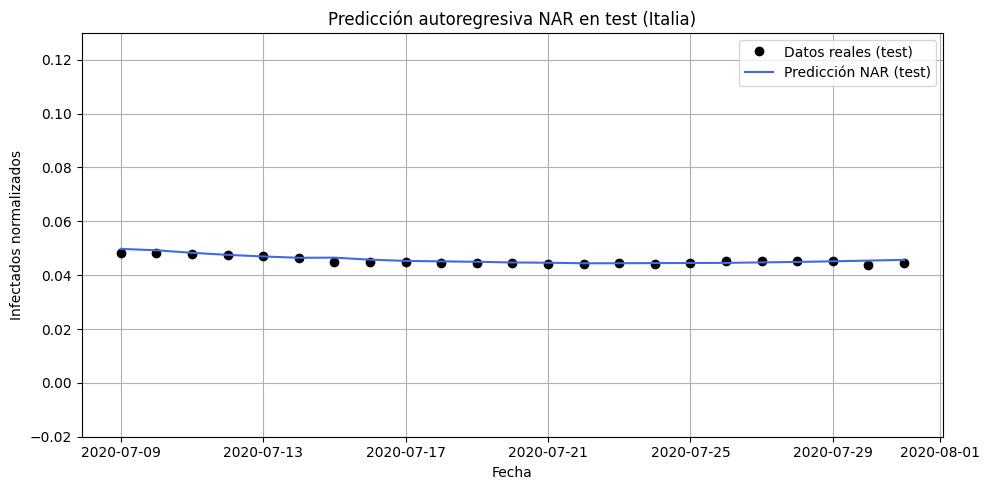

In [22]:
d = 7  # tamaño de la ventana

X_train_nar, y_train_nar, fechas_nar = preparar_datos_nar(df_modelo_it, d)
model_nar = entrenar_nar(X_train_nar, y_train_nar, d)
graficar_nar(model_nar, X_train_nar, y_train_nar, fechas_nar, df_reales_it_test, d, label='Italia')


Epoch 0, Loss: 0.033368
Epoch 500, Loss: 0.000007
Epoch 1000, Loss: 0.000006
Epoch 1500, Loss: 0.000006
Epoch 2000, Loss: 0.000005
Epoch 2500, Loss: 0.000003
Epoch 3000, Loss: 0.000003
Epoch 3500, Loss: 0.000003
Epoch 4000, Loss: 0.000002
Epoch 4500, Loss: 0.000002


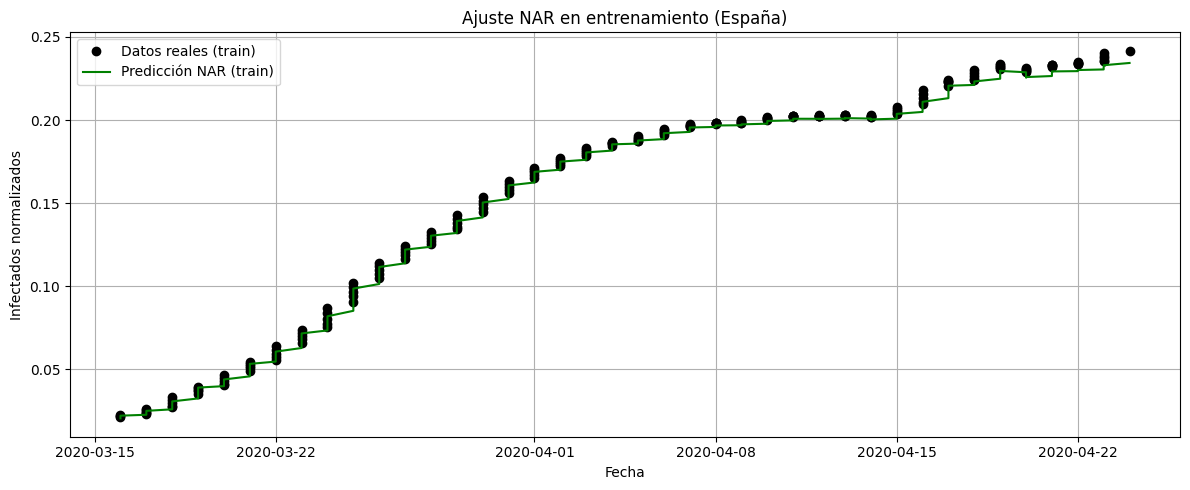

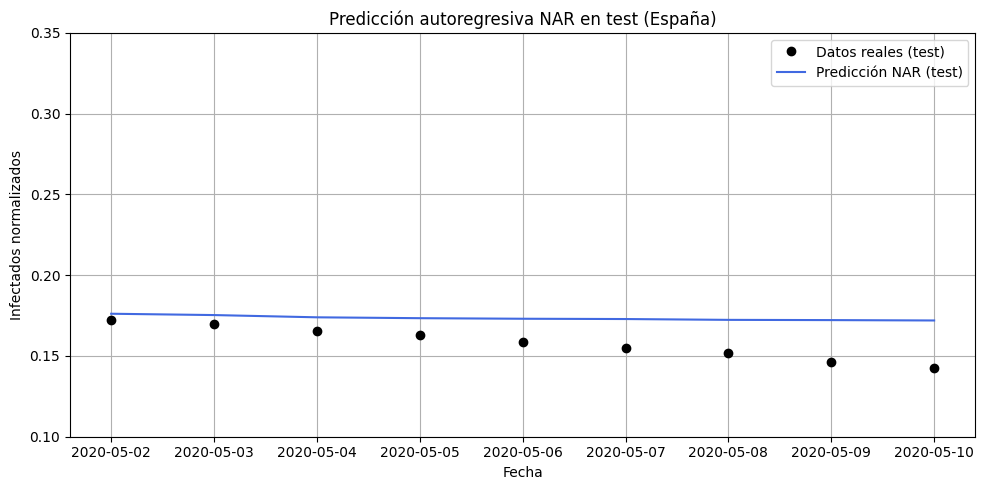

In [24]:
d = 7  # tamaño de la ventana

X_train_nar, y_train_nar, fechas_nar = preparar_datos_nar(df_modelo_es, d)
model_nar = entrenar_nar(X_train_nar, y_train_nar, d)
graficar_nar(model_nar, X_train_nar, y_train_nar, fechas_nar, df_reales_es_test, d, label='España')


Epoch 0, Loss: 0.265128
Epoch 500, Loss: 0.000006
Epoch 1000, Loss: 0.000005
Epoch 1500, Loss: 0.000005
Epoch 2000, Loss: 0.000005
Epoch 2500, Loss: 0.000004
Epoch 3000, Loss: 0.000003
Epoch 3500, Loss: 0.000002
Epoch 4000, Loss: 0.000002
Epoch 4500, Loss: 0.000011


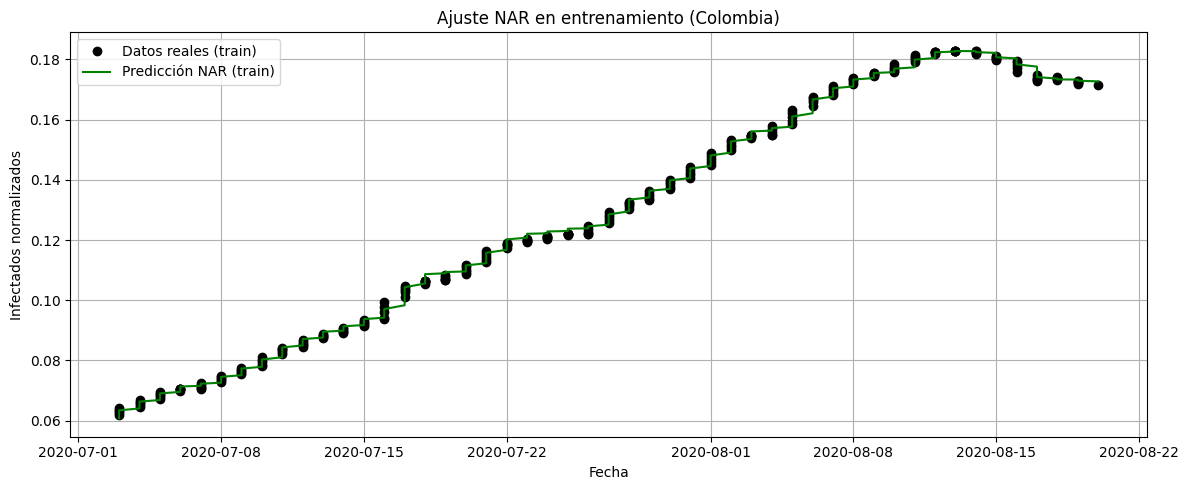

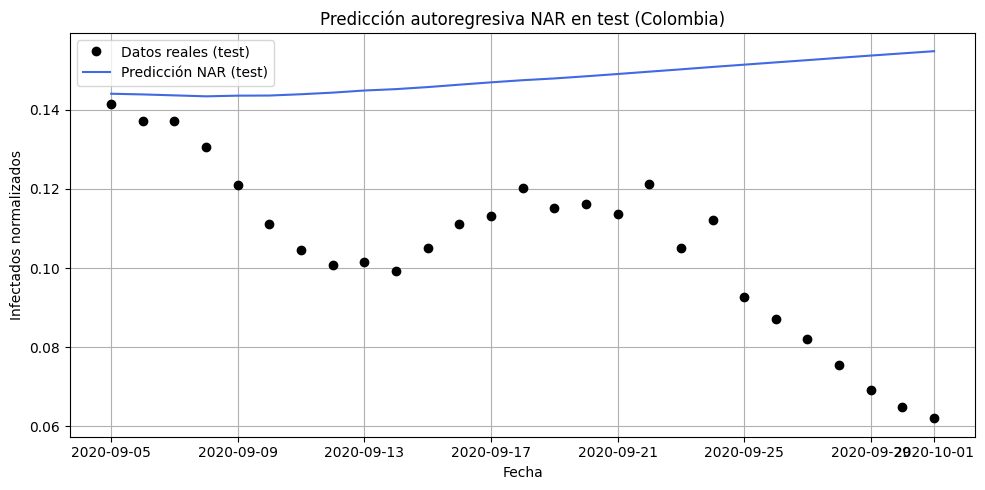

In [27]:
d = 15  # tamaño de la ventana

X_train_nar, y_train_nar, fechas_nar = preparar_datos_nar(df_modelo_col, d)
model_nar = entrenar_nar(X_train_nar, y_train_nar, d)
graficar_nar(model_nar, X_train_nar, y_train_nar, fechas_nar, df_reales_col_test, d, label='Colombia')
